In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis

import pynumtools.kmc as kmc

#mpl.rcParams['figure.figsize'] = (13, 13)
import matplotlib.pyplot as plt
import scipy.signal as ss
from readdy_learn.example.regulation_network import RegulationNetwork

/srv/public/clonker/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
regulation_network = RegulationNetwork()
regulation_network.timestep = 6e-3
regulation_network.realisations = 1

In [3]:
analysis = regulation_network.generate_analysis_object()

In [4]:
for i in range(len(regulation_network.initial_states)):
    print("traj {}".format(i))
    t = analysis.generate_or_load_traj_lma(i, regulation_network.target_time,
                                           noise_variance=regulation_network.noise_variance,
                                           realizations=regulation_network.realisations)
    t.persist()
regulation_network.compute_gradient_derivatives(analysis)

traj 0
traj 1
traj 2
traj 3
species 0 dx.shape (500,)
species 3 dx.shape (500,)
species 6 dx.shape (500,)
species 0 dx.shape (500,)
species 3 dx.shape (500,)
species 6 dx.shape (500,)
species 0 dx.shape (500,)
species 3 dx.shape (500,)
species 6 dx.shape (500,)
species 0 dx.shape (500,)
species 3 dx.shape (500,)
species 6 dx.shape (500,)


In [5]:
print("noise variance: {}".format(regulation_network.noise_variance))
print("target time: {}".format(regulation_network.target_time))
print("lma realizations: {}".format(regulation_network.realisations))
print("timestep: {}".format(regulation_network.timestep))
print("initial states:")
for init in regulation_network.initial_states:
    print("\t{}".format(init))

noise variance: 0.0001
target time: 3.0
lma realizations: 60
timestep: 0.006
initial states:
	[[1 0 0 1 0 0 1 0 0]]
	[[1 2 0 1 0 3 1 0 0]]
	[[1.  1.  2.  1.  0.  2.5 1.  0.  2. ]]
	[[1 1 2 1 0 0 1 4 0]]


In [6]:
analysis.get_traj(1).counts.shape

(500, 9)

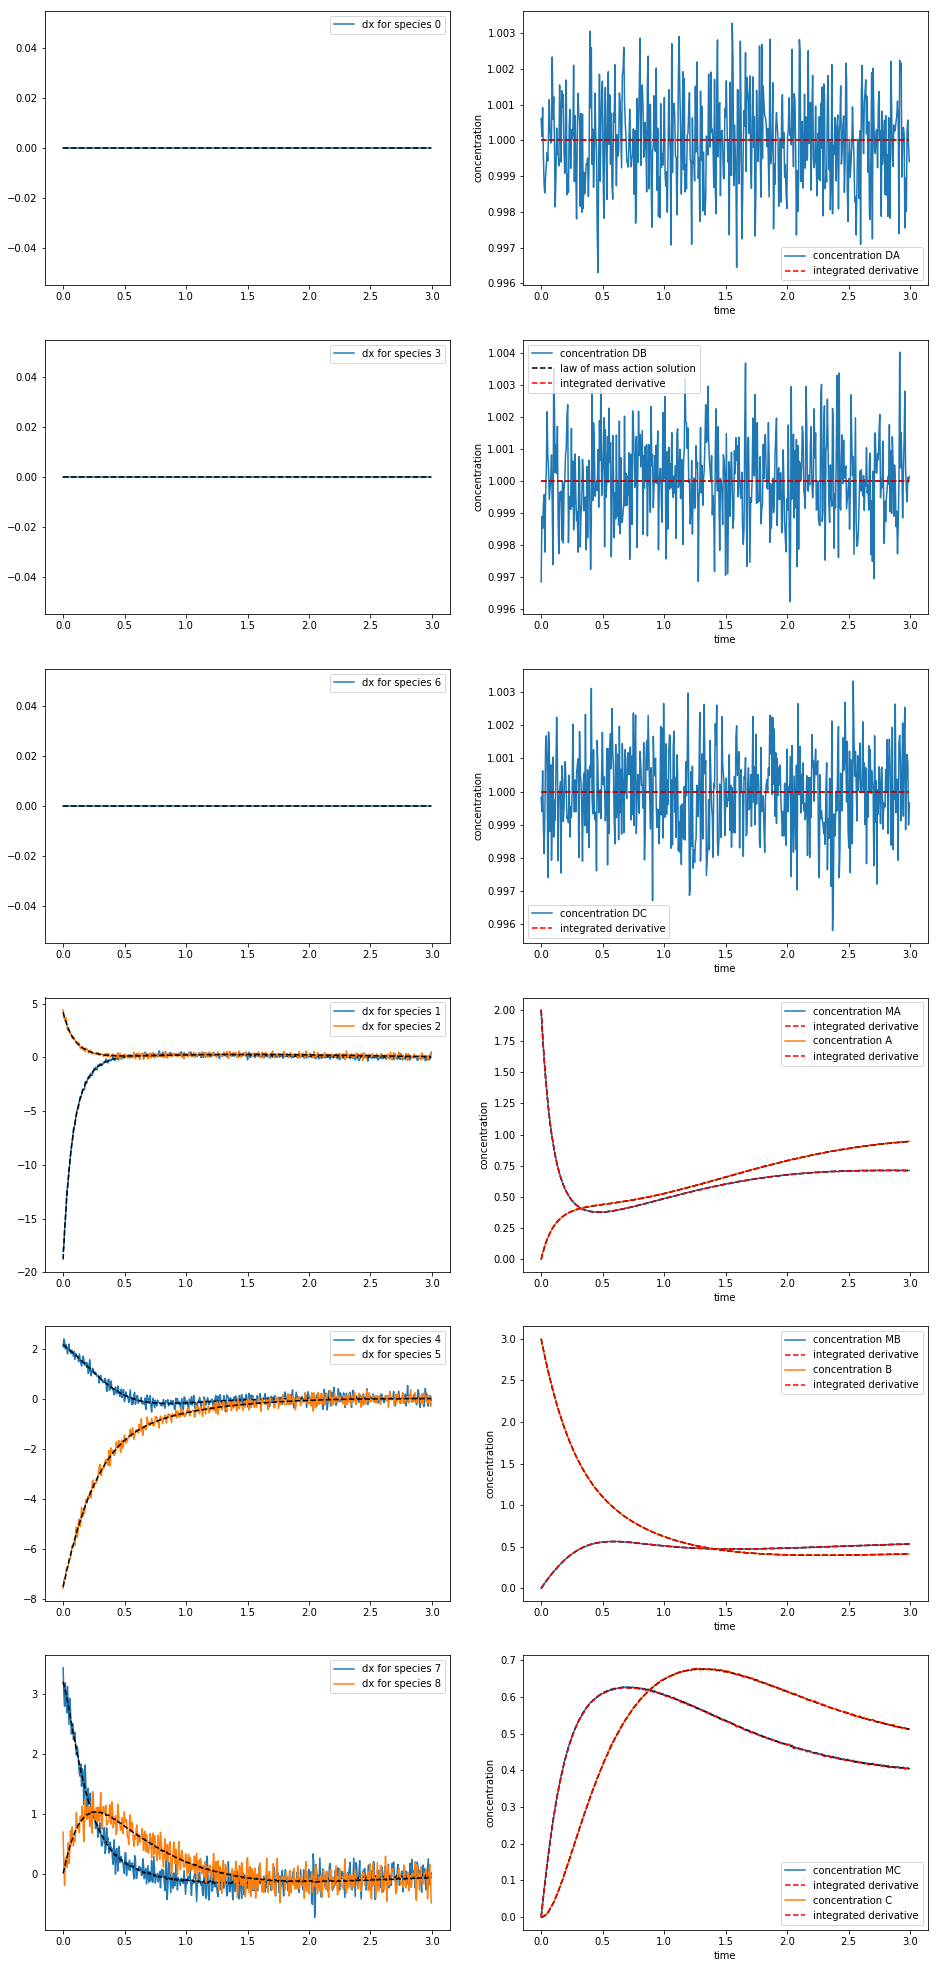

In [7]:
regulation_network.plot_concentrations(analysis, 1)

In [8]:
#alphas = np.concatenate((
#        np.linspace(0.000001,0.0001,num=16),
#        np.linspace(0.0002,0.012,num=16),
#        np.linspace(0.012,0.1,num=8)))
alphas = np.logspace(-6., 0., num=40)

In [9]:
cv_res = analysis.elastic_net_cv([i for i in range(4)], alphas=alphas, l1_ratios=np.linspace(0., 1., num=3), 
                                 recompute=False)

In [10]:
cv_res.result

array([{'scores': [-0.07061140379662306, -0.07164698737411726, -0.1812063226248854, -0.0966544037925364], 'alpha': 5.1794746792312125e-05, 'l1_ratio': 0.0},
       {'scores': [-0.07062192676986777, -0.07101881967308776, -0.11201045255460858, -0.08595639752591079], 'alpha': 7.196856730011514e-06, 'l1_ratio': 0.0},
       {'scores': [-0.07062380342156396, -0.0709641797541514, -0.10241544268542338, -0.08434311874390876], 'alpha': 1e-06, 'l1_ratio': 1.0},
       {'scores': [-0.07062381211366502, -0.07096870371471736, -0.103170034077295, -0.08449860521970913], 'alpha': 1e-06, 'l1_ratio': 0.5},
       {'scores': [-0.07062184963046647, -0.07097871687839669, -0.1063359995380851, -0.08478282296046324], 'alpha': 7.196856730011514e-06, 'l1_ratio': 0.5},
       {'scores': [-0.0706238207920852, -0.07097333758016512, -0.10392514697671176, -0.08465936093073526], 'alpha': 1e-06, 'l1_ratio': 0.0},
       {'scores': [-0.07060963996094327, -0.07107916317981648, -0.13083848286723862, -0.08690858451920845]

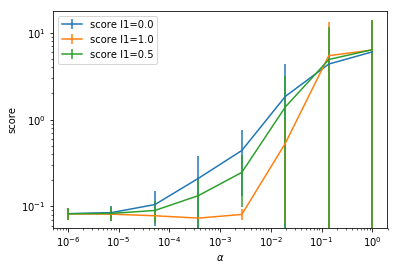

In [11]:
def plot_cv_results2(cv):
    xs = {}
    ys = {}
    allys = {}
    for r in cv.result:
        l1_ratio = r['l1_ratio']
        if len(r['scores']) > 0:
            if l1_ratio in xs.keys():
                xs[l1_ratio].append(r['alpha'])
                ys[l1_ratio].append(r['scores'])
                allys[l1_ratio].append(r['scores'])
            else:
                xs[l1_ratio] = [r['alpha']]
                ys[l1_ratio] = [r['scores']]
                allys[l1_ratio] = [r['scores']]
    for l1_ratio in xs.keys():
        l1xs = np.array(xs[l1_ratio])
        l1ys_scores = np.array(ys[l1_ratio])
        l1ys = np.mean(l1ys_scores, axis=1)
        l1yserr = np.std(l1ys_scores, axis=1)
        l1allys = np.array([np.array(arr) for arr in allys[l1_ratio]]).T
        sorts = np.argsort(l1xs)
        l1xs = l1xs[sorts]
        l1ys = l1ys[sorts]
        l1yserr = l1yserr[sorts]

        l1allys = [arr[sorts] for arr in l1allys]
        plt.errorbar(l1xs, -l1ys, yerr=l1yserr, label='score l1={}'.format(l1_ratio))

        for ix, _ys in enumerate(l1allys):
            if np.argmin(-_ys) != 0:
                # print("found one: {} with argmin {}".format(ix, np.argmin(_ys)))
                pass
            # ax.plot(l1xs, -_ys, label='test set {}'.format(ix))
            pass
    plt.ylabel('score')
    plt.xlabel('$\\alpha$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
plot_cv_results2(cv_res)

In [12]:
alpha, l1_ratio, score = ana.best_params(cv_res)
print("got alpha={}, l1_ratio={}, score={}".format(alpha, l1_ratio, score))

got alpha=0.0003727593720314938, l1_ratio=1.0, score=0.0733754728272801


In [13]:
rates = analysis.solve([i for i in range(4)], alpha, l1_ratio, tol=1e-14)

In [14]:
l1_norm = sum([abs(r) for r in regulation_network.desired_rates])
print("L1 norm of desired rates = {}".format(l1_norm))
alpha = 7.6e-06
print("L1 norm * alpha = {}".format(alpha * l1_norm))

L1 norm of desired rates = 39.400000000000006
L1 norm * alpha = 0.00029944000000000005


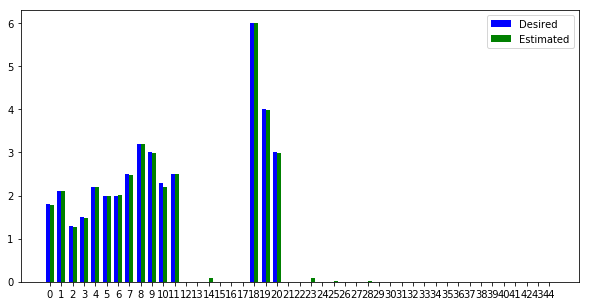

In [15]:
ana.plot_rates_bar(regulation_network.desired_rates, rates)
#plt.title("L1 regularization")

optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
130 / 30000 iterations


Text(0.5,1,'Least-squares')

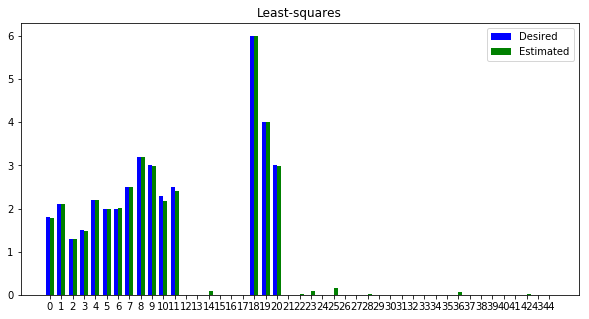

In [22]:
lsq_rates = analysis.least_squares([0, 1, 2, 3], tol=1e-14, recompute=True)
ana.plot_rates_bar(regulation_network.desired_rates, lsq_rates)
plt.title("Least-squares")

In [23]:
lsq_rates - rates

array([ 4.06524367e-03,  3.70436191e-03,  7.72463576e-03, -1.93403427e-02,
        8.43647605e-03,  1.05975471e-02, -1.98665515e-04,  5.62986181e-03,
        2.36619567e-03, -9.40337414e-03, -1.41657006e-03, -9.30755332e-02,
       -1.58801348e-03,  4.91038906e-03,  4.99524636e-03,  1.84470166e-03,
        1.97039028e-03,  0.00000000e+00,  5.24572785e-04,  2.31285314e-02,
       -4.39606462e-04, -7.22479021e-18,  8.46012695e-03,  4.99524636e-03,
        0.00000000e+00,  1.43255138e-01,  7.45907488e-19,  0.00000000e+00,
        5.91220124e-03,  2.38756152e-03,  4.79483283e-19, -2.43377584e-03,
       -2.00449149e-18, -1.70872132e-03,  0.00000000e+00,  1.26444007e-03,
        5.31319799e-02,  0.00000000e+00, -9.55808345e-19, -1.75991137e-03,
       -4.62786634e-05,  4.73926072e-19,  1.98069178e-02, -1.18761724e-03,
       -4.21675913e-04])

In [24]:
np.sum(rates)

39.39872404612448

In [25]:
np.sum(lsq_rates)

39.58481572593346

In [26]:
np.sum(regulation_network.desired_rates)

39.400000000000006

# ESTRATES

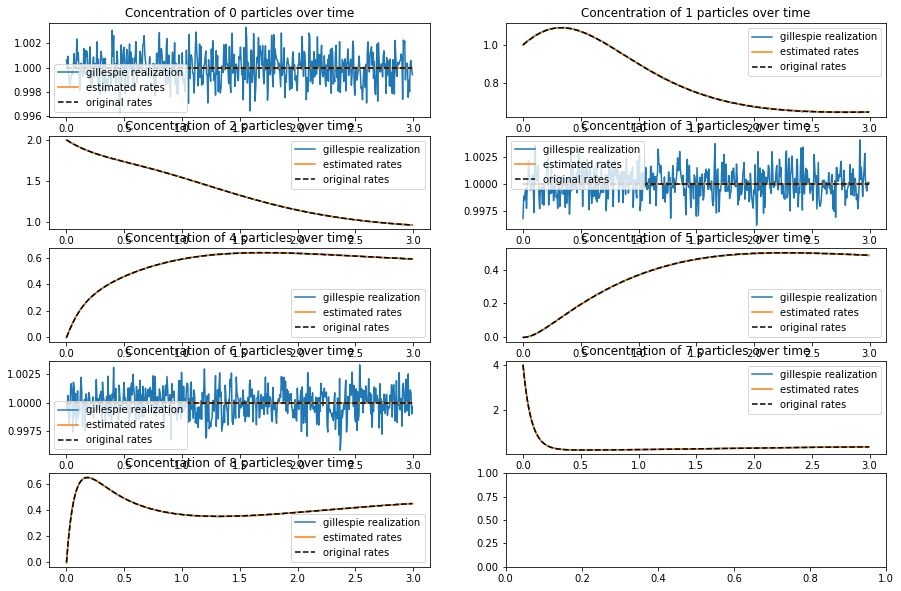

In [31]:
analysis.plot_results(3, rates)

# LSQ

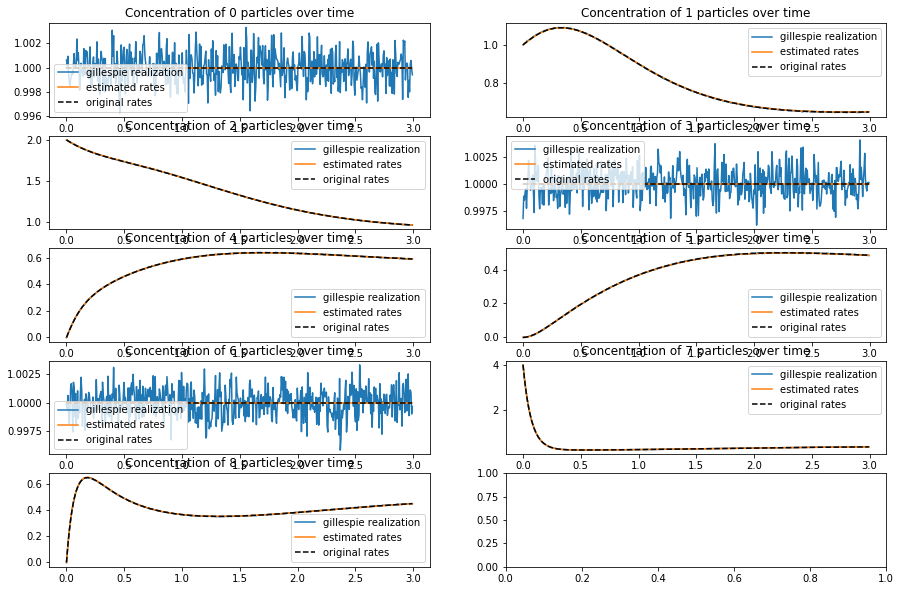

In [35]:
analysis.plot_results(3, lsq_rates)

## save result

In [24]:
if noise_variance>0.:
    est_rates_path = os.path.join("simple_gradient", "est_rates_for_"+str(realisations)+".npy")
    cv_results_path = os.path.join("simple_gradient", "cv_results_for_"+str(realisations)+".pickle")
else:
    est_rates_path = os.path.join("simple_gradient", "est_rates_for_infty.npy")
    cv_results_path = os.path.join("simple_gradient", "cv_results_for_infty.pickle")

np.save(est_rates_path, est_rates)
with open(cv_results_path, "wb") as file:
    pickle.dump(cv_res, file, protocol=pickle.HIGHEST_PROTOCOL)